# Práctica 4. Segmentación de imágenes II
## Apertura y pasos previos

In [1]:
import numpy as np
import pydicom as pdc
import matplotlib.pyplot as plt
import cv2

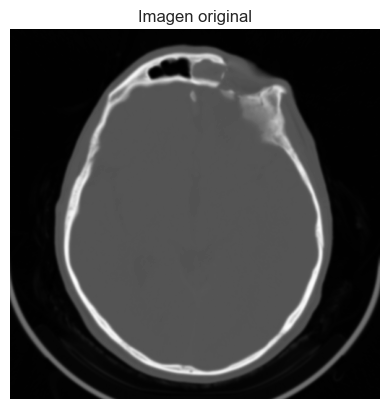

In [2]:
# Abrir la imagen
def abrir_imagen(num_imagen):
    return pdc.dcmread(fr"C:\Users\Gonzalo_MA\Desktop\Universidad\Tercero\Imagenes biomedicas\Practica 1/im{num_imagen}.dcm")

imagen = abrir_imagen(8)

# Guardar la imagen en una matriz de datos indicando los bits por pixel
def imagen_bits(imagen, bpp = 12):
    if bpp == 12:
        sol = np.array(imagen.pixel_array)
    elif bpp == 8:
        sol = (np.array(imagen.pixel_array) * (255/4095)).astype(np.uint8)
    return sol, bpp

# Creaamos la matriz de la imagen con 12 bpp
imagen_pixeles, bpp = imagen_bits(imagen, 12)

# Visualizamos la imagen
plt.imshow(imagen_pixeles, cmap = 'gray') # cmap = "gray", camp = "jet", cmap = "viridis"
plt.axis('off')
plt.title("Imagen original")
plt.show()

In [3]:
def ventana(imagen, vmin, vmax):
    # Clipeado de la imagen entre los umbrales
    clipeada = np.clip(imagen, a_min=vmin, a_max=vmax)
    # Reescalamiento para que la ventana ocupe todos los valores de píxeles
    clipeada = ((clipeada - vmin)/(vmax - vmin))*((2**bpp)-1)
    return clipeada.astype(np.uint16)

def gauss(imagen, tamano = 5, desviacion = 1):
    # Creamos el kernel
    t =  tamano//2
    kernel = np.fromfunction(lambda x, y:
                             (1/ (2 * np.pi * desviacion ** 2)) * np.exp(-((x - t) ** 2 + (y - t) ** 2) / (2 * desviacion ** 2)),
                             (tamano, tamano))
    suma_kernel = np.sum(kernel)

    # Pad de la imagen e inicialización  
    im_pad = np.pad(imagen, t)
    im_filtrada = np.zeros((512, 512))

    # Aplicamos la convolucion
    for x in range(t, 512+t):
        for y in range(t, 512+t):
            im_filtrada[x-t, y-t] = (np.sum(kernel * im_pad[x-t:x+t+1, y-t:y+t+1]))/(suma_kernel)

    return im_filtrada.astype(np.uint16)

In [4]:
v = (ventana(imagen_pixeles, 1030, 1080) * (255/4095)).astype(np.uint8)
v_filtrada = (gauss(v) * (255/4095)).astype(np.uint8)

## Crecimiento de regiones
### Función

In [105]:
def crecimiento_region(imagen, semilla, umbral):
    # Tamaño de la imagen
    rows, columns = imagen.shape
    
    # Pixeles que ya se han comprobado / mascara final
    pixeles_visitados = np.zeros_like(imagen, dtype=np.bool_)
    region = np.zeros_like(imagen, dtype=np.bool_)
    
    # Lista con los valores a comprobar
    lista = [semilla]
    
    # Inicializacion de la media y desviacion
    numero_pixeles = 1
    media = imagen[semilla[0], semilla[1]]
    desviacion = 0
    
    # Comprobamos los valores de la lista
    while len(lista) > 0:
        x, y = lista.pop()
        pixeles_visitados[x, y] = True
        
        # Comprobamos condicion de crecimiento
        if abs(imagen[x,y] - media) <= (1-(desviacion/media))*umbral:
            # Añadimos a la mascara final
            region[x,y] = True
            
            # Actualizamos los criterios
            media = ((numero_pixeles*media)+imagen[x,y])/(numero_pixeles+1)
            numero_pixeles += 1          
            desviacion = np.std(imagen, where=region==True)
            
            # Añadimos los pixeles con conectividad 8 a la cola
            for i in range(max(0, x - 1), min(x + 2, rows)):
                for j in range(max(0, y - 1), min(y + 2, columns)):
                    if pixeles_visitados[i,j] == False:
                        lista.append([i,j])
    return region

### Semilla

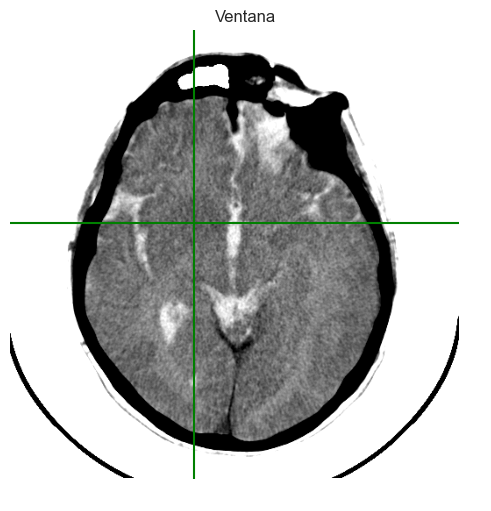

In [182]:
_, ax = plt.subplots(figsize = (10, 5), layout = "constrained")

ax.imshow(np.max(v) - v, cmap="gray")
ax.axis("off")
ax.set_title("Ventana")
plt.vlines(x = 210, ymin = 0, ymax = 512, colors = "green")
plt.hlines(y = 220, xmin = 0, xmax = 512, colors = "green")

plt.show()

### Visualización

In [117]:
ROI_sinFiltar = crecimiento_region(v, [210, 220], 22)

In [109]:
ROI_filtrada = crecimiento_region(v_filtrada, [210, 220], 2)

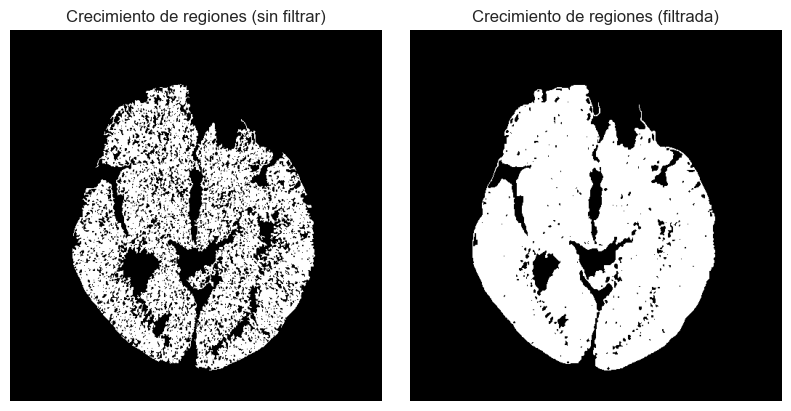

In [119]:
_, ax = plt.subplots(1, 2, figsize=(8,4), layout="constrained")
ax[0].imshow(ROI_sinFiltar, cmap = "gray")
ax[0].axis(False)
ax[0].set_title("Crecimiento de regiones (sin filtrar)")
ax[1].imshow(ROI_filtrada, cmap="gray")
ax[1].axis(False)
ax[1].set_title("Crecimiento de regiones (filtrada)")

plt.show()

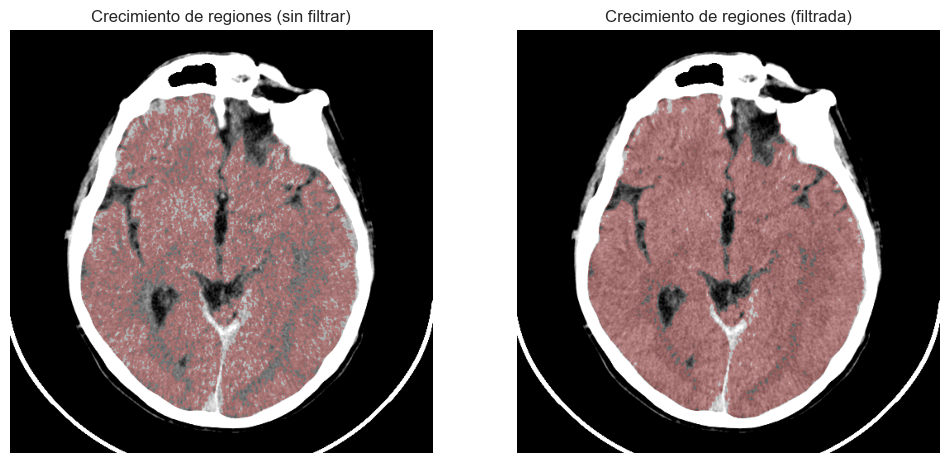

In [170]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 2, figsize=(12,6))
cmap_mascara = mcolors.ListedColormap(['none', 'red'])

ax[0].imshow(v, cmap='gray')
ax[0].imshow(ROI_sinFiltar, cmap=cmap_mascara, alpha=0.2)
ax[0].grid(False)
ax[0].axis(False)
ax[0].set_title("Crecimiento de regiones (sin filtrar)")

ax[1].imshow(v, cmap='gray')
ax[1].imshow(ROI_filtrada, cmap=cmap_mascara, alpha=0.2)
ax[1].grid(False)
ax[1].axis(False)
ax[1].set_title("Crecimiento de regiones (filtrada)")

plt.show()

## Cierre

In [146]:
def dilatacion(imagen, elem_estruc):
    t = elem_estruc.shape[0]//2
    rows, columns = imagen.shape 
    
    imagen_dilatada = np.zeros_like(imagen, dtype=np.bool_)
    # Elemento estructurante cuadrado
    #imagen_pad = np.pad(imagen, pad_width=t ,mode="edge")
    for x in range(t, rows-t-1):
        for y in range(t, columns-t-1):
            convolucion = np.logical_and(imagen[x-t:x+t+1, y-t:y+t+1], elem_estruc)
            if True in convolucion:
                imagen_dilatada[x,y] = True
    return imagen_dilatada


def erosion(imagen, elem_estruc):
    imagen_inversa = np.logical_not(imagen)
    erosion = np.logical_not(dilatacion(imagen_inversa, elem_estruc))
    
    # Correción de los bordes
    erosion[0,:] = False
    erosion[-1,:] = False
    erosion[:,0] = False
    erosion[:,-1] = False
    return erosion

### Máscara sobre imagen sin filtrar

In [150]:
elemento_estructurante = np.ones((3,3), dtype=np.bool_)
ROI_dilatacion = dilatacion(ROI_sinFiltar, elemento_estructurante)
ROI_cierre = erosion(ROI_dilatacion, elemento_estructurante)

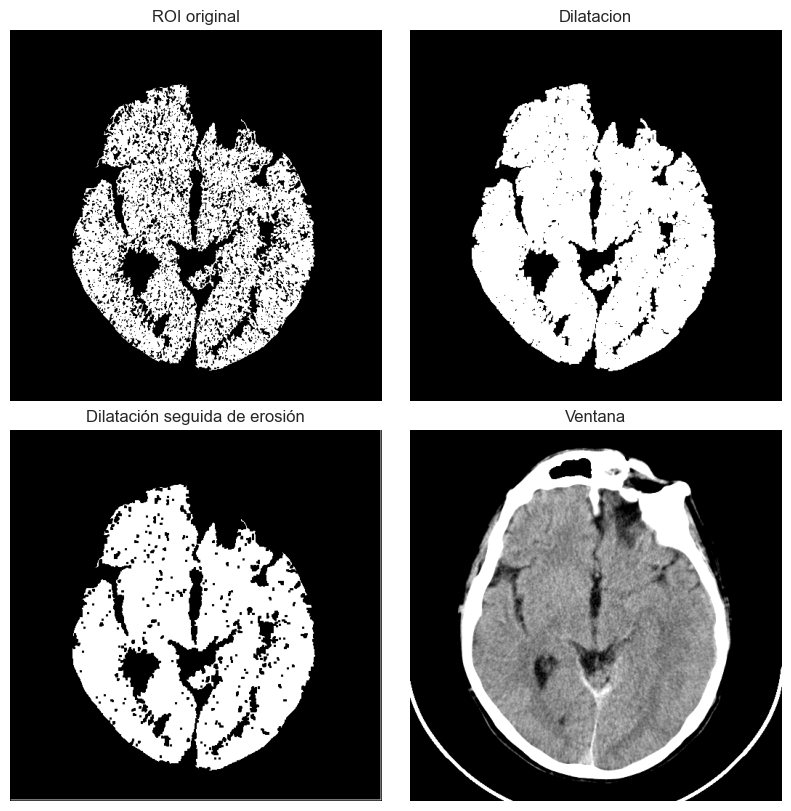

In [151]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")

ax[0,0].imshow(ROI_sinFiltar, cmap="gray")
ax[0,0].axis("off")
ax[0,0].set_title("ROI original")
ax[0,1].imshow(ROI_dilatacion, cmap="gray")
ax[0,1].axis("off")
ax[0,1].set_title("Dilatacion")
ax[1,0].imshow(ROI_cierre, cmap="gray")
ax[1,0].axis("off")
ax[1,0].set_title("Dilatación seguida de erosión")
ax[1,1].imshow(v, cmap="gray")
ax[1,1].axis("off")
ax[1,1].set_title("Ventana")

plt.show()

### Máscara sobre imagen filtrada

In [147]:
ROI_dilatacion_f = dilatacion(ROI_filtrada, elemento_estructurante)
ROI_cierre_f = erosion(ROI_dilatacion_f, elemento_estructurante)

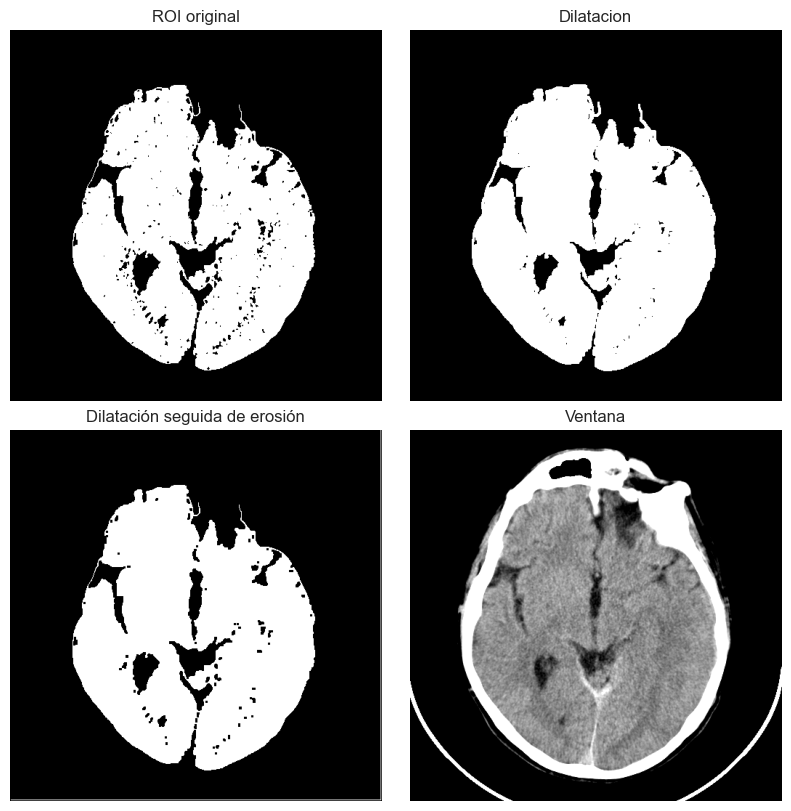

In [148]:
_, ax = plt.subplots(2, 2, figsize = (8, 8), layout = "constrained")

ax[0,0].imshow(ROI_filtrada, cmap="gray")
ax[0,0].axis("off")
ax[0,0].set_title("ROI original")
ax[0,1].imshow(ROI_dilatacion_f, cmap="gray")
ax[0,1].axis("off")
ax[0,1].set_title("Dilatacion")
ax[1,0].imshow(ROI_cierre_f, cmap="gray")
ax[1,0].axis("off")
ax[1,0].set_title("Dilatación seguida de erosión")
ax[1,1].imshow(v, cmap="gray")
ax[1,1].axis("off")
ax[1,1].set_title("Ventana")

plt.show()

### Comparación

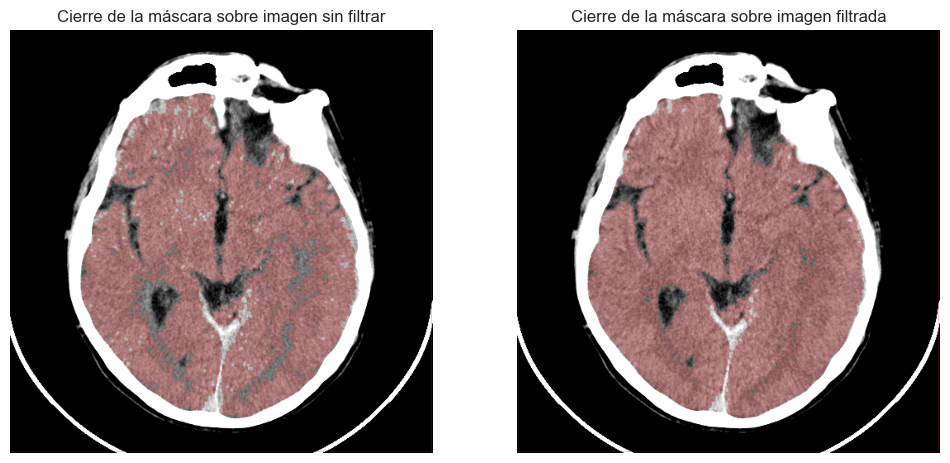

In [183]:
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 2, figsize=(12,6))
cmap_mascara = mcolors.ListedColormap(['none', 'red'])

ax[0].imshow(v, cmap='gray')
ax[0].imshow(ROI_cierre, cmap=cmap_mascara, alpha=0.2)
ax[0].grid(False)
ax[0].axis(False)
ax[0].set_title("Cierre de la máscara sobre imagen sin filtrar")

ax[1].imshow(v, cmap='gray')
ax[1].imshow(ROI_cierre_f, cmap=cmap_mascara, alpha=0.2)
ax[1].grid(False)
ax[1].axis(False)
ax[1].set_title("Cierre de la máscara sobre imagen filtrada")

plt.show()

## Descriptores básicos

In [190]:
# Contorno externo 
contornos, _ = cv2.findContours(ROI_cierre_f.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
primer_contorno = contornos[0]

# Calculamos el perímetro, área y compacidad
perimetro = cv2.arcLength(primer_contorno, closed=True)
area = cv2.contourArea(primer_contorno)
compacidad = (perimetro**2) / area

print("Perímetro:", round(perimetro, 1))
print("Área:", round(area, 1))
print("Compacidad:", round(compacidad, 1))
print("Circularidad:", round(4*np.pi*area/(perimetro**2) , 1))
print("Media:", round(np.mean(v, where=ROI_cierre_f==True), 1))
print("Desviación estándar:", round(np.std(v, where=ROI_cierre_f==True), 1))

valores, cuenta = np.unique(v, return_counts= True)
cuenta = cuenta[1:-1]
print("Moda:", valores[np.argmax(cuenta)-1])

# Contorno en la imagen original
imagen_contorno = cv2.drawContours(ROI_cierre_f.astype(np.uint8).copy(), [primer_contorno], -1, (255, 255, 255), 2)

Perímetro: 1625.4
Área: 91880.0
Compacidad: 28.8
Circularidad: 0.4
Media: 141.6
Desviación estándar: 23.2
Moda: 132


### Contorno

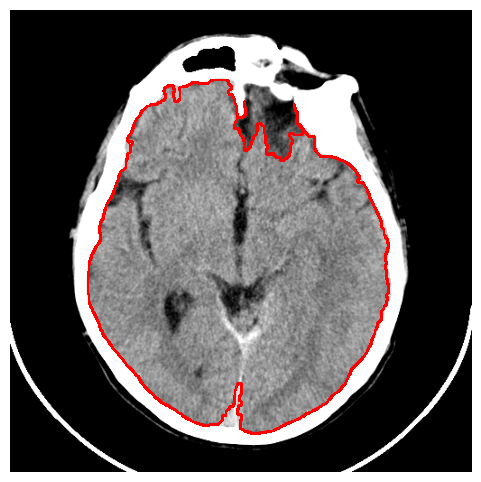

In [189]:
_, ax = plt.subplots(figsize=(6,6))
contorno = imagen_contorno==255
cmap_mascara = mcolors.ListedColormap(['none', 'red'])

ax.imshow(v, cmap = "gray")
ax.imshow(contorno, cmap = cmap_mascara)
ax.grid(False)
ax.axis(False)
plt.show()